In [1]:
import torch # type: ignore
from torch import nn # type: ignore
from torch.utils.data import Dataset,DataLoader # type: ignore
from torchvision import transforms # type: ignore
import matplotlib.pyplot as plt # type: ignore
from PIL import Image # type: ignore
from torchvision.models import vgg19_bn,VGG19_BN_Weights # type: ignore
import numpy as np # type: ignore
import os
import glob
from torch.functional import F # type: ignore
import albumentations as A # type: ignore
from albumentations.pytorch import ToTensorV2

## 构造数据集

In [3]:

class MyDataset(Dataset):
    def __init__(self, data_dir=r"C:\Users\Alex\Downloads\DRIVE", image_size=(224,224), is_train=True, transform=None):
        super().__init__()
        self.transform = transform
        self.is_train = is_train
        self.image_size = image_size
        self.images_list, self.mask_list = self.read_data_list_from(data_dir, self.is_train)
        
        # 定义默认的Albumentations增强
        if self.transform is None:
            if self.is_train:
                self.aug = A.Compose([
                    A.Resize(256, 256),
                    A.RandomCrop(224, 224),
                    A.HorizontalFlip(p=0.5),
                    A.Rotate(limit=4, p=0.5),
                    A.VerticalFlip(p=0.5),
                    A.OneOf([
                        A.Blur(blur_limit=3, p=0.5),
                        A.ColorJitter(p=0.5),
                        A.RandomBrightnessContrast(brightness_limit=0.2, p=0.6),
                    ], p=1.0),
                    A.Normalize(mean=[0, 0, 0], std=[1,1,1]),
                    ToTensorV2()
                ], additional_targets={'mask': 'mask'})
            else:
                self.aug = A.Compose([
                    A.Resize(image_size[0], image_size[1]),
                    A.Normalize(mean=[0, 0, 0], std=[1,1,1]),
                    ToTensorV2()
                ], additional_targets={'mask': 'mask'})
        else:
            self.aug = self.transform

    def __len__(self):
        return len(self.images_list)
    
    def __getitem__(self, index):
        image_path = self.images_list[index]
        mask_path = self.mask_list[index]
        
        # 读取图像和mask，转换mask中的255为1
        image = np.array(Image.open(image_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"))
        mask = (mask == 255).astype(np.uint8)  # 提前转换255为1
        
        # 应用数据增强
        augmented = self.aug(image=image, mask=mask)
        image = augmented['image']
        mask = augmented['mask']
        
        return image, mask
    
    def read_data_list_from(self, data_dir, is_train):
        if is_train:
            data_dir = os.path.join(data_dir, "training")
        else:
            data_dir = os.path.join(data_dir, "test")
        
        images = glob.glob(os.path.join(data_dir, "images", "*.tif"))
        masks = []
        for img_path in images:
            base_name = os.path.basename(img_path).split("_")[0]
            mask_name = f"{base_name}_manual1.gif"
            mask_path = os.path.join(data_dir, "1st_manual", mask_name)
            masks.append(mask_path)
        
        return images, masks

In [4]:
train_data=DataLoader(MyDataset(),batch_size=6,num_workers=0,shuffle=True)
test_data=DataLoader(MyDataset(is_train=False),batch_size=6,num_workers=0)

## 开始网络编码

In [5]:
class ConvBlock(nn.Module):
    def __init__(self,in_channels,out_channels,padding_mod="reflect",kernel=3,stride=1,padding=1):
        super().__init__()
        self.Conv=nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=kernel,stride=stride,padding=padding,padding_mode=padding_mod),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(out_channels,out_channels,kernel_size=kernel,stride=stride,padding=padding,padding_mode=padding_mod),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Dropout(0.3),
        )
    def forward(self,x):
        return self.Conv(x)


In [6]:
class Unet(nn.Module):
    def __init__(self,C=2):
        ## downsample
        super().__init__()
        self.backbend=vgg19_bn(weights=VGG19_BN_Weights.DEFAULT).features
        # for param in self.backbend.parameters():
        #     param.requires_grad = False
        self.down1=nn.Sequential(self.backbend[:6])## 64 224 224
        self.down2=nn.Sequential(self.backbend[6:13])## 128 112 112
        self.down3=nn.Sequential(self.backbend[13:26])## 256 56 56
        self.down4=nn.Sequential(self.backbend[26:39])## 512 28 28
        self.down5=nn.Sequential(self.backbend[39:52])## 512 14 14
        self.bottleneck=nn.Sequential(
            nn.MaxPool2d(kernel_size=2,stride=2),
            ConvBlock(512,1024))## 1024 7 7

        ## upsample
        self.up5=nn.ConvTranspose2d(1024,1024,kernel_size=2,stride=2,padding=0)## 1024 14 14
        self.conv5=ConvBlock(1024+512,512)
        self.up4=nn.ConvTranspose2d(512,512,kernel_size=2,stride=2,padding=0)## 512 28 28
        self.conv4=ConvBlock(512+512,256)
        self.up3=nn.ConvTranspose2d(256,256,kernel_size=2,stride=2,padding=0)## 256 56 56
        self.conv3=ConvBlock(256+256,128)
        self.up2=nn.ConvTranspose2d(128,128,kernel_size=2,stride=2,padding=0)## 128 112 112
        self.conv2=ConvBlock(128+128,64)
        self.up1=nn.ConvTranspose2d(64,64,kernel_size=2,stride=2,padding=0)## 64 224 224
        self.conv1=ConvBlock(64+64,64)
        self.final_conv=nn.Conv2d(64,C,kernel_size=1,stride=1,padding=0)

    def forward(self,x):
         down1=self.down1(x)
         down2=self.down2(down1)
         down3=self.down3(down2)
         down4=self.down4(down3)
         down5=self.down5(down4)
         bottle=self.bottleneck(down5)

         up5=self.up5(bottle)
         cat5=torch.cat((up5,down5),dim=1)
         conv5=self.conv5(cat5)

         up4=self.up4(conv5)
         cat4=torch.cat((up4,down4),dim=1)
         conv4=self.conv4(cat4)

         up3=self.up3(conv4)
         cat3=torch.cat((up3,down3),dim=1)
         conv3=self.conv3(cat3)

         up2=self.up2(conv3)
         cat2=torch.cat((up2,down2),dim=1)
         conv2=self.conv2(cat2)

         up1=self.up1(conv2)
         cat1=torch.cat((up1,down1),dim=1)
         conv1=self.conv1(cat1)
         return self.final_conv(conv1)

In [7]:
unet=Unet()

In [8]:
def try_gpu(i=0):
    if torch.cuda.device_count()>=i+1:
        return torch.device(f"cuda:{i}")
    return torch.device('cpu')

In [9]:
## 定义损失函数

class FocalLoss(nn.Module):

    def __init__(self,gamma=2.0,alpha=0.25,ignore_index=-1):
        super().__init__()
        self.gamma=gamma
        self.alpha=alpha
        self.ignore_index=ignore_index

    def forward(self,inputs,targets):
        predict=inputs.permute(0,2,3,1).contiguous()
        predict=torch.softmax(predict,dim=-1)
        b,c=predict.size(0),predict.size(-1)
        mask=targets!=self.ignore_index## (N,H,W)
        predict=predict[mask].view(-1,c)
        targets=targets[mask].view(-1)
        class_mask=torch.eye(c,device=predict.device)
        targets=class_mask[targets].view(-1,c)
        FL=(-self.alpha*(1-predict)**self.gamma*targets*torch.log(predict)).sum(dim=1)
        return FL.mean()

In [10]:
class Accumulator():
    def __init__(self,n):
        self.s=[0.0]*n
    def add(self,*args):
        self.s=[a+float(b) for a,b in zip(self.s,args)]
    def __getitem__(self,idx):
        return self.s[idx]

In [19]:
## 定义训练函数
def train(net,train_iter,val_iter,lr,num_epochs,device=None,patience=100):
    # def init_weights(m):
    #     if isinstance(m,nn.Conv2d):
    #         nn.init.kaiming_normal(m.weight)
    # net.apply(init_weights)
    history=[]
    best_val_loss=0.03578
    counter=0
    net.to(device)
    print('training on',device)
    loss=FocalLoss(ignore_index=-1)
    optimizer=torch.optim.Adam(net.parameters(),lr=lr,weight_decay=5e-4)
    batch_size=len(train_iter)
    for epoch in range(num_epochs):
        net.train()
        metric=Accumulator(2)
        print(f"epoch{epoch+1}")
        for i,(X,y) in enumerate(train_iter):
            X,y=X.to(device),y.to(device)
            y=y.squeeze(1).long()
            y_hat=net(X)
            l=loss(y_hat,y)
            optimizer.zero_grad()
            l.sum().backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l,l.numel())
            if (i+1)%(1)==0 or i==batch_size-1:
                print(f'\tloss {metric[0]:.5f}')
        ## 验证模式
        net.eval()
        metric2=Accumulator(2)
        with torch.no_grad():
            for X,y in val_iter:
                X,y=X.to(device),y.to(device)
                y=y.squeeze(1).long()
                y_hat=net(X)
                l2=loss(y_hat,y)
                metric2.add(l2,l2.numel())
        print(f'epoch {epoch+1} summary: loss {metric[0]:.5f}, val_loss {metric2[0]:.5f}')
        if metric2[0]<best_val_loss:
            best_val_loss=metric2[0]
            torch.save(net.state_dict(),'model_best_unet.pth')
        else:
            counter+=1
            if counter>=patience:
                print('early stops')
                break
        print(f"best val_loss {best_val_loss:.5f}")
        history.append(metric[0])
    return history

In [20]:
## 开始训练！
history=train(unet,train_data,test_data,lr=1e-3,num_epochs=50,device=try_gpu())

training on cuda:0
epoch1
	loss 0.01394
	loss 0.03175
	loss 0.04685
	loss 0.06398
epoch 1 summary: loss 0.06398, val_loss nan
best val_loss 0.03578
epoch2
	loss 0.01472
	loss 0.03109
	loss 0.04456
	loss 0.05712
epoch 2 summary: loss 0.05712, val_loss 0.04493
best val_loss 0.03578
epoch3
	loss 0.01418
	loss 0.02834
	loss 0.04541
	loss 0.05843
epoch 3 summary: loss 0.05843, val_loss 0.03906
best val_loss 0.03578
epoch4
	loss 0.01374
	loss 0.02779
	loss 0.04048
	loss 0.05757
epoch 4 summary: loss 0.05757, val_loss 0.03998
best val_loss 0.03578
epoch5
	loss 0.01468
	loss 0.02776
	loss 0.04117
	loss 0.05605
epoch 5 summary: loss 0.05605, val_loss 0.03820
best val_loss 0.03578
epoch6
	loss 0.01320
	loss 0.02703
	loss 0.04067
	loss 0.05319
epoch 6 summary: loss 0.05319, val_loss 0.03940
best val_loss 0.03578
epoch7
	loss 0.01538
	loss 0.02950
	loss 0.04296
	loss 0.05507
epoch 7 summary: loss 0.05507, val_loss 0.04234
best val_loss 0.03578
epoch8
	loss 0.01248
	loss 0.02598
	loss 0.03967
	loss

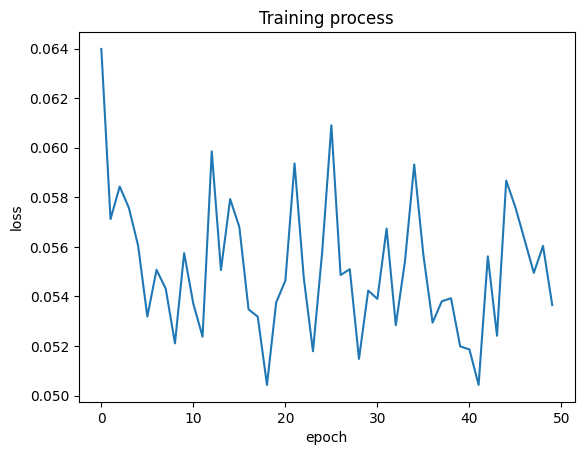

In [21]:
plt.plot(history)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training process')
plt.show()

### 在测试集上验证模型

In [27]:
## 定义预测函数
def predict(net,data_iter,num=3,idx=2):
    unet.load_state_dict(torch.load("model_best.pth"))
    iters=iter(data_iter)
    for j in range(idx-1):
        next(iters)
    image,target=next(iters)
    images,targets=[],[]
    net.to(try_gpu())
    net.eval()
    with torch.no_grad():
        pred=net(image.to(try_gpu()))
    for i in range(num):
        images.append(image[i].permute(1,2,0).detach().cpu())
        targets.append(target[i].detach().cpu())
    return images,targets,pred

In [36]:
origin,targets,preds=predict(unet,test_data,idx=1)

C:\Users\Alex\AppData\Local\Temp\ipykernel_7976\2629528595.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet.load_state_dict(torch.load("model_best.pth"))


In [37]:
predicted=preds.argmax(1)
predicted.shape

torch.Size([6, 224, 224])

In [38]:
preds=[predicted[i].detach().cpu() for i in range(6)]
len(preds)

6

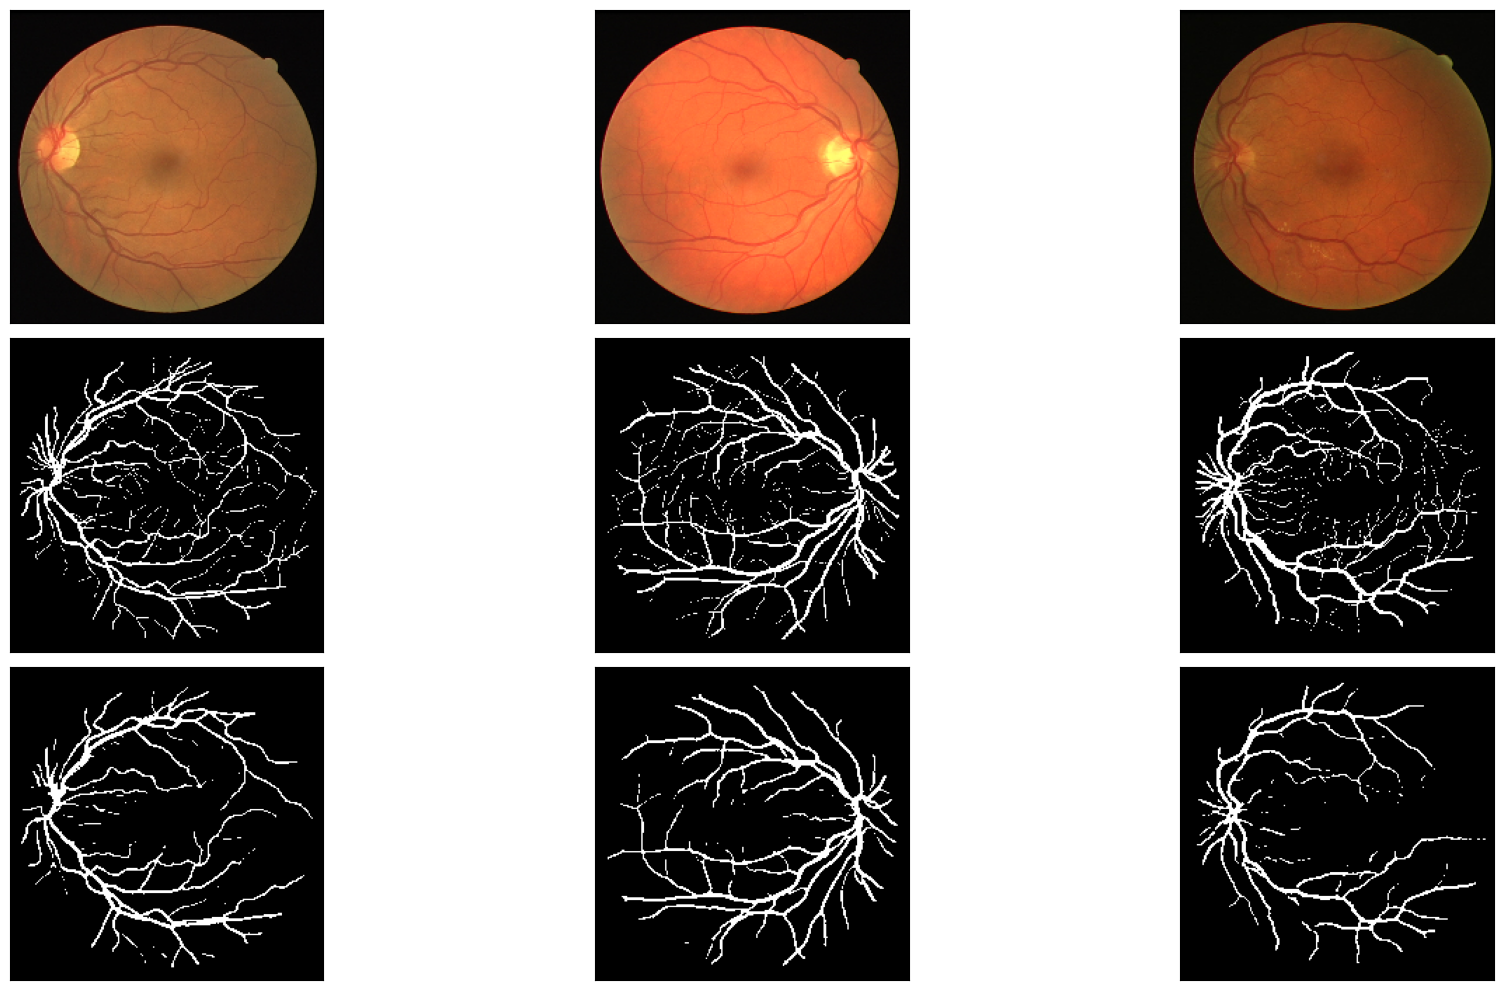

In [39]:
fig,axes=plt.subplots(3,3,figsize=(20,10))
for i in range(3):
    axes[0,i].imshow(origin[i])
    axes[0,i].set_xticks(())
    axes[0,i].set_yticks(())
for i in range(3):
    axes[1,i].imshow(targets[i],cmap="gray")
    axes[1,i].set_xticks(())
    axes[1,i].set_yticks(())
for i in range(3):
    axes[2,i].imshow(preds[i],cmap="gray")
    axes[2,i].set_xticks(())
    axes[2,i].set_yticks(())
fig.tight_layout()
plt.show()